In [1]:
!pip install fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

The [MovieLens](https://grouplens.org/datasets/movielens/) dataset contains 25m movie rankings, each a combination of a move ID, a user ID and a numeric rating. We will use a subset of 100,000.

In [3]:
from fastai.collab import * # Collaborative filtering library
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
ratings_df = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                         names=['user', 'movie', 'rating', 'timestamp'])
ratings_df.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies_df = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies_df.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings_df = ratings_df.merge(movies_df)

In [7]:
ratings_df.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Use `fastai.collab.CallabDataLoaders.from_df` to create a dataloaders from a `DataFrame`. By default, takes first column for users, second column for items, third column for ratings. We will manually specify items column.

In [8]:
dataloaders = CollabDataLoaders.from_df(ratings_df, item_name='title', bs=64)
dataloaders.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


### Latent Factors

To represent collaborative filtering in Pytorch we can't just use crosstab representation directly to fit into our deep learning framework. We can represent our movie and user latent factor tables as simple matrices. These latent factors will represent traits like whether a person likes scifi or historical movies and whether a movie fits in the scifi or historical genre; whether a person likes a certain director or actor and whether a movie features that director or actor etc. The model will figure all this out from the high-level data we give it.

In [9]:
dataloaders.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [10]:
n_users = len(dataloaders.classes['user'])
n_movies = len(dataloaders.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors) # Shape: (944 x 5)
movie_factors = torch.randn(n_movies, n_factors) # Shape: (1665 x 5)

To index our latent factor matrices to find factors for a particular user or movie, we multiply the matrix by a one-hot vector.

In [11]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3 # Shapes (5 x 944) @ (944, 1) = (5 x 1)

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [12]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

To access these latency factors, PyTorch and other deep learning libraries use a method called 'embedding' which is just a way to pretend to multiply by a one-hot-encoded matrix by using the computational shortcut of simply indexing the factor matrix. Actually the matrix multiplication doesn't happen at all, but it just looks nice mathematically.

We will define a class `DotProduct` that inherits from the PyTorch `Module` class. The class must have a `forward` method which our `Learner` will call for forward pass. This will serve as our model, with the output being a dot product between a user's factors and a movie's factors.

With the `Embedding class` storing our factors we can pretend to matrix multiply factor matrix with one-hot vectors by simply indexing the factor matrix to get the factor vectors corresponding to the user id's and movie id's in the batch.

In [13]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors): ## Initialise factors using the Embedding class
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, xb):
        users = self.user_factors(xb[:,0])
        movies = self.movie_factors(xb[:,1])
        return (users * movies).sum(dim=1) # Returns a batch of output scalars, each a dot product.

Our batch of inputs `xb` is a batch of items each with two values: the user id and the movie id.

In [14]:
xb, yb = dataloaders.one_batch()
xb.shape

torch.Size([64, 2])

### Tabular Learner

Baseline

In [15]:
model = DotProduct(n_users, n_movies, 50)
learner = Learner(dataloaders, model, loss_func=MSELossFlat())

In [16]:
learner.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:08
1,1.093331,1.109981,00:08
2,0.958258,0.990199,00:08
3,0.814234,0.894916,00:08
4,0.780714,0.882022,00:08


Lets add a sigmoid activation function to squish outputs into the range [-0.5, 5.5] to match the rating targets (slightly higher than 5 and lower than 0 has been found to give better results, maybe because it prevents output explosion).

In [31]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(-0.5, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [32]:
model = DotProduct(n_users, n_movies, 50, y_range=[0, 5])
learn = Learner(dataloaders, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.983638,0.992803,00:08
1,0.903838,0.909584,00:08
2,0.715092,0.866793,00:08
3,0.561315,0.851362,00:08
4,0.455987,0.853378,00:08


In [36]:
model = DotProduct(n_users, n_movies, 50, y_range=[-0.5, 5.5])
learn = Learner(dataloaders, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.027997,1.007881,00:08
1,0.869506,0.925950,00:08
2,0.716267,0.861138,00:08
3,0.508191,0.858459,00:08
4,0.406383,0.860328,00:08


#### Biases

Some users are more or less generous in their ratings, and some movies are just plain good or bad. We want to adjust ratings for certain users and movies such that all ratings are comparable. To do this we introduce **biases**.

In [44]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(-0.5,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0]) # Shape: (bs x n_factors)
        movies = self.movie_factors(x[:,1]) # Shape: (bs x n_factors)
        res = (users * movies).sum(dim=1, keepdim=True) # Shape: (bs x 1)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [41]:
model = DotProductBias(n_users, n_movies, 50, y_range=(-0.5, 5.5))
learn = Learner(dataloaders, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.945769,0.949496,00:09
1,0.844211,0.874282,00:09
2,0.621876,0.857846,00:09
3,0.419998,0.877050,00:09
4,0.297689,0.881836,00:09


#### Weight Decay

In theory, the scaled sum of the square of all parameters is added to the loss before back propagation. In practice, the scaled and doubled parameters are added to the gradients before the step (parameter update).

In [21]:
model = DotProductBias(n_users, n_movies, 50)
learner = Learner(dataloaders, model, loss_func=MSELossFlat())
learner.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:09
1,0.888625,0.882614,00:09
2,0.771066,0.832743,00:09
3,0.599807,0.822374,00:09
4,0.504981,0.822528,00:09


### Making our own Embedding module

An `Embedding` object holds all the latency factors for the users and the items. These factors can be treated as parameters of the model.

We need to be considerate of the modules that the parameters will interact with, namely the optimizer. To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to return when calling `Module`'s `parameters` method.

In [22]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)
        
L(T().parameters())

(#0) []

In [23]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

All PyTorch modules use the `nn.Parameter` wrapper for any trainable parameters. This is automatically included in `nn.Module` subclasses, for example:

In [24]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [25]:
type(t.a.weight)

torch.nn.parameter.Parameter

Let's use the `nn.Parameter` wrapper to create our latency factors.

In [26]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))
create_params([8, 5]) # 8 factor vectors each with 5 latency factors

Parameter containing:
tensor([[ 2.7011e-03,  1.7831e-03,  1.4344e-02, -5.9904e-03,  1.4285e-02],
        [-2.6364e-03,  6.7935e-03, -1.8902e-03,  9.9224e-03, -6.4258e-03],
        [-2.0772e-02, -5.8074e-03, -6.1577e-03,  3.1277e-03,  2.2624e-03],
        [-5.4037e-03, -3.3610e-03,  1.7993e-02,  2.6980e-03, -2.0602e-03],
        [-2.6676e-03,  1.5687e-03, -1.3735e-02, -5.7147e-03, -3.4682e-04],
        [ 9.2645e-04,  1.7902e-03, -4.0306e-04,  1.1657e-02,  8.6121e-03],
        [ 2.0379e-03,  8.2552e-03, -6.7525e-03, -9.9305e-04, -1.5820e-03],
        [ 3.7102e-03, -5.4695e-05, -2.3774e-02, -2.7958e-03, -5.4461e-03]], requires_grad=True)

In [4]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(-0.5,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]] # Select the factor vectors corrspnding to the user id's in the batch 
        movies = self.movie_factors[x[:,1]] # Select the factor vectors corrspnding to the movie id's in the batch 
        res = (users*movies).sum(dim=1) # (64 x 5) --> (64 x 1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]] # (64 x 1) + (64 x 1) + (64 x 1)
        return sigmoid_range(res, *self.y_range)

NameError: name 'Module' is not defined

In [43]:
model = DotProductBias(n_users, n_movies, 50, y_range=[-0.5, 5.5])
learner = Learner(dataloaders, model, loss_func=MSELossFlat())
learner.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936682,0.956785,00:09
1,0.874492,0.893744,00:09
2,0.751042,0.844477,00:09
3,0.597923,0.822540,00:10
4,0.494632,0.823308,00:09


#### Interpretting embeddings and biases

Movies with greatest negtaive bias, means that even when it is very relevant to a user (dot product highly positive), it is generally rated low (needs negative bias to match its low target).

In [47]:
movie_bias = learner.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

NameError: name 'dls' is not defined

Conversely...

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dataloaders.classes['title'][i] for i in idxs]

#### Embedding Distances

In [3]:
movie_factors = learner.model.i_weight.weight
idx = dataloaders.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dataloaders.classes['title'][idx]

NameError: name 'learner' is not defined

#### Principle Component Analysis

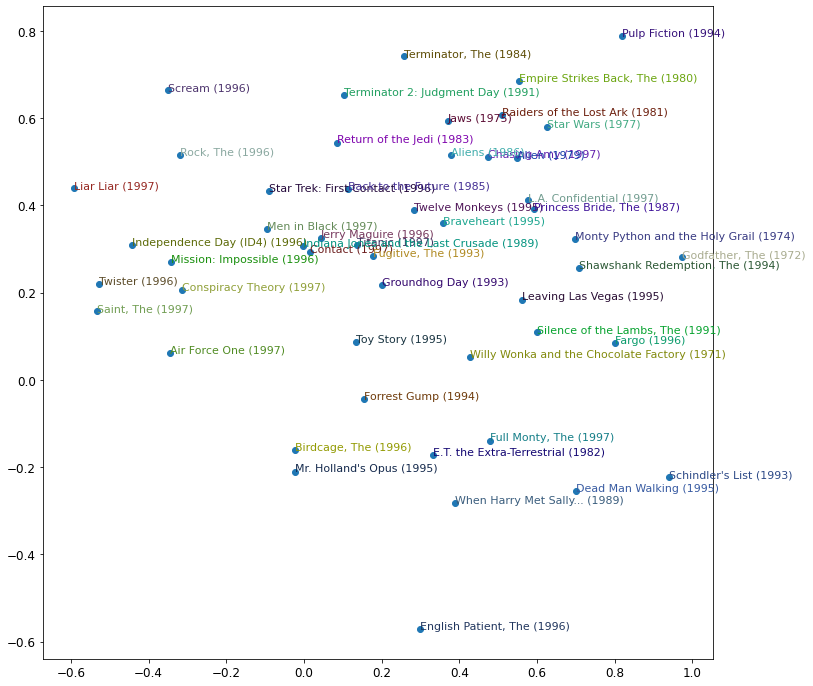

In [50]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings_df.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Horizontal axis seems to roughly imply pop culture vs classics.

### Using fastai.collab

In [45]:
learner = collab_learner(dataloaders, n_factors=50, y_range=(-0.5, 5.5))

In [46]:
learner.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.976179,0.962277,00:09
1,0.859094,0.894111,00:09
2,0.752247,0.840299,00:09
3,0.621906,0.821744,00:09
4,0.525141,0.821533,00:09


In [48]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [53]:
movie_bias = learner.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dataloaders.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 'Titanic (1997)',
 "Schindler's List (1993)",
 'Star Wars (1977)']

### Deep Learning for Collaborative Filtering

In [57]:
embs = get_emb_sz(dataloaders)
embs

[(944, 74), (1665, 102)]

In [58]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [60]:
model = CollabNN(*embs)
learn = Learner(dataloaders, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.938363,0.964845,00:10
1,0.912096,0.900825,00:10
2,0.841604,0.883330,00:09
3,0.838730,0.871196,00:10
4,0.751490,0.874045,00:09


fastai provides this model in `fastai.collab` if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:

In [62]:
learn = collab_learner(dataloaders, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.990502,0.985775,00:12
1,0.923084,0.924833,00:12
2,0.901504,0.888484,00:12
3,0.846963,0.868195,00:11
4,0.759809,0.864918,00:11
